In [1]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
import math
from imageio import imread
from skimage.transform import resize
from keras.models import Model
import os.path
import numpy as np
import random
import matplotlib.pyplot as plt
from os.path import join as pJoin

Using TensorFlow backend.


In [2]:
def ColorMask(Mask, Color):
    RGBImage = np.stack([Mask, Mask, Mask], axis = 2)
    return np.multiply(RGBImage, Color)

def getModelName(FileDir):
    Files = os.listdir(ModelDir)
    for File in Files:
        if '.h5' in File:
            return File

def getProbIndex(ProbMatrix):
    MaxIndex = np.argmax(np.squeeze(ProbMatrix), axis = 2)
    return MaxIndex

def getObjective(IndexMatrix, Objective):
    return (IndexMatrix == Objective).astype('float32')

In [3]:
def UNetFull(img_rows, img_cols, img_channels):  # 23 trainable layers, use same padding, en lugar de unpadding layers
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv7)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
    
    conv9 = Conv2D(1024, (3, 3), padding='same', activation='relu')(pool4)
    conv10 = Conv2D(1024, (3, 3), padding='same', activation='relu')(conv9)
    
    # Decoder
    convT1 = Conv2D(512, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv10))
    merge1 = concatenate([convT1, conv8], axis=3)
    conv11 = Conv2D(512, (3, 3), padding='same', activation='relu')(merge1)
    conv12 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv11)
    
    convT2 = Conv2D(256, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv12))
    merge2 = concatenate([convT2, conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), padding='same', activation='relu')(merge2)
    conv14 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv13)
    
    convT3 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv14))
    merge3 = concatenate([convT3, conv4], axis=3)
    conv15 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge3)
    conv16 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv15)
    
    convT4 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv16))
    merge4 = concatenate([convT4, conv2], axis=3)
    conv17 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge4)
    conv18 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv17)

    y = Conv2D(2, (1, 1), activation='softmax')(conv18)

    return Model(inputs=x, outputs=y)

def UNetMedium(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv5)
    
    # Decoder   
    convT1 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv6))
    merge1 = concatenate([convT1, conv4], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge1)
    conv8 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv7)
    
    convT2 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv8))
    merge2 = concatenate([convT2, conv2], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge2)
    conv10 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv9)  

    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv10)

    return Model(inputs=x, outputs=y)

def UNetSmall(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    
    # Decoder   
    convT = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv4))
    merge = concatenate([convT, conv2], axis=3)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge)
    conv6 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv5)
    
    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv6)

    return Model(inputs=x, outputs=y)

In [4]:
ModelDir = 'D:\OpenVINO\\ResUnet'
ModelName = getModelName(ModelDir)
ModelFile = pJoin(ModelDir, ModelName)
ModelArch = int(ModelName[0])

In [5]:
# Cargar Modelo con nuevas dimensiones para pruebas
NewSize = (480, 640)

if ModelArch == 0:
    model = UNetFull(NewSize[0], NewSize[1], 3)
elif ModelArch == 1:
    model = UNetMedium(NewSize[0], NewSize[1], 3)
else:
    model = UNetSmall(NewSize[0], NewSize[1], 3)

model.load_weights(ModelFile)

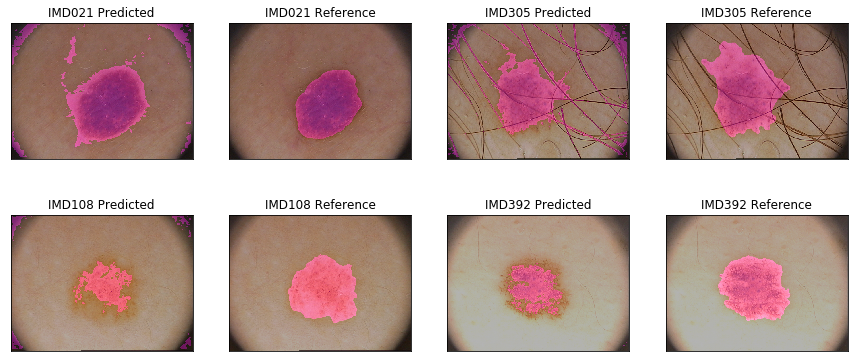

In [6]:
DatasetDir = 'D:\OpenVINO\PH2'
TestImages = 4
plt.rcParams['figure.figsize'] = (15, 5*(math.ceil(TestImages/4) + 1))
SourceDir = DatasetDir +'\\validation'
ImageNames = os.listdir(pJoin(SourceDir,'images'))
random.shuffle(ImageNames)
i = 1
ShapeColor = [1, 0, 1]
FigureRows = math.ceil(TestImages/2) + 1

for Image in ImageNames[0: TestImages]:
    
    InputImage = imread(pJoin(SourceDir, 'images', Image))
    Reference = imread(pJoin(SourceDir, 'labels', Image))
    
    InputImage = resize(InputImage, NewSize, mode='constant', anti_aliasing=False)
    Reference = resize(Reference, NewSize, mode='constant', anti_aliasing=False)
    
    y = model.predict(np.expand_dims(InputImage, axis=0))
    PrdIndex = getProbIndex(y)
    PrdMask = getObjective(PrdIndex, 0)
    
    PrdMask = ColorMask(PrdMask, ShapeColor)
    GTMask = ColorMask(Reference, ShapeColor)
    
    plt.subplot(FigureRows, 4, i)
    plt.imshow(InputImage, interpolation='none')
    plt.imshow(PrdMask, interpolation='none', alpha=0.3)
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
    plt.title(Image.split('.')[0] + ' Predicted')
    i += 1
    
    plt.subplot(FigureRows, 4, i)
    plt.imshow(InputImage, interpolation='none') 
    plt.imshow(GTMask, interpolation='none', alpha=0.3) 
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
    plt.title(Image.split('.')[0] + ' Reference')
    i += 1

plt.savefig(ModelDir + '\\Comparison' +'.png', bbox_inches='tight')
plt.show()